In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from yahoo_fin.stock_info import get_data

In [2]:
ticker_name = "GOOGL" #ticker name of stock
stock_price = get_data(ticker_name, start_date="12/04/2009", index_as_date=True)
stock_price.tail()

,open,high,low,close,adjclose,volume,ticker
2023-04-04,104.330002,105.580002,104.040001,104.720001,104.720001,24420100,GOOGL
2023-04-05,105.779999,106.099998,103.660004,104.470001,104.470001,28290500,GOOGL
2023-04-06,105.260002,109.169998,104.330002,108.419998,108.419998,48711500,GOOGL
2023-04-10,106.980003,107.589996,105.120003,106.440002,106.440002,27067400,GOOGL
2023-04-11,106.550003,106.730003,104.680000,105.349998,105.349998,26270300,GOOGL


In [3]:
len(stock_price['close']), stock_price.isnull().sum()

(3359,
 open        0
 high        0
 low         0
 close       0
 adjclose    0
 volume      0
 ticker      0
 dtype: int64)

In [4]:
stock_price = stock_price.dropna()
stock_price.isnull().sum()
stock_price.reset_index();

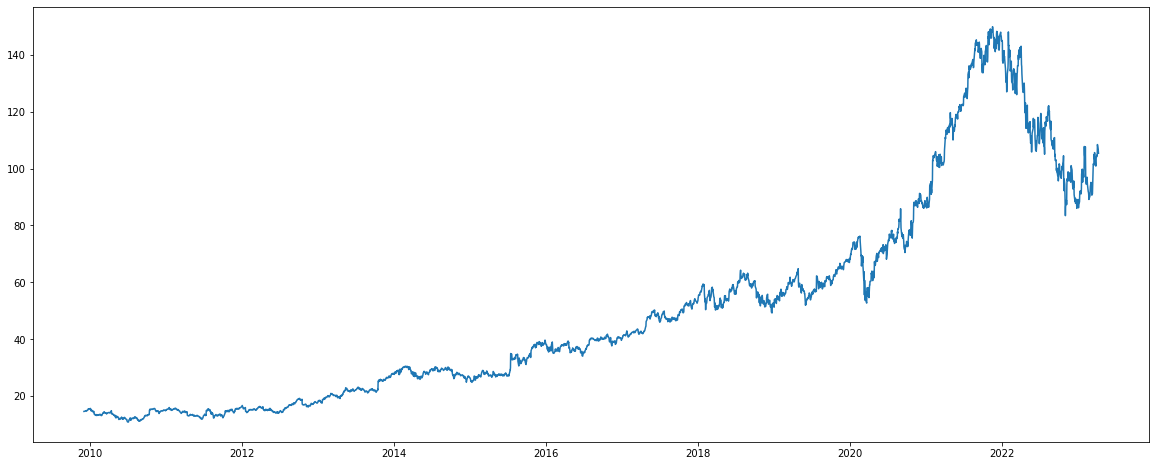

In [5]:
plt.figure(figsize=(20, 8))
plt.plot(stock_price['close'])

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(0, 1))
data = scaler.fit_transform(np.array(stock_price['close']).reshape(-1,1))


In [7]:

pd.DataFrame(data).isnull().sum()

0    0
dtype: int64

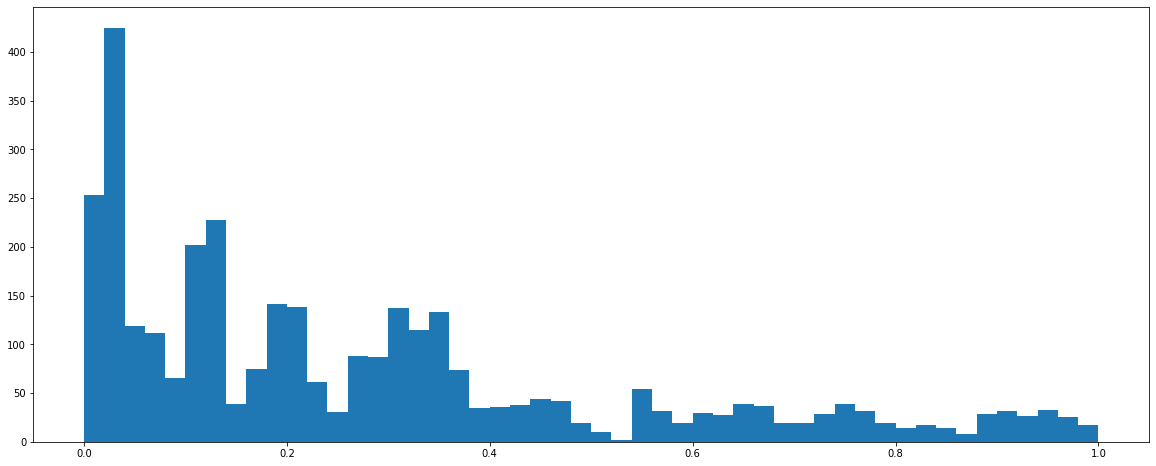

In [8]:
plt.figure(figsize=(20, 8))
plt.hist(data, bins=50);

In [9]:
training_size = int(len(data)*0.7)
test_size = len(data)-training_size
train_data, test_data = data[0:training_size,:], data[training_size:len(data), :1]

In [10]:
train_data.shape, test_data.shape, data.shape

((2351, 1), (1008, 1), (3359, 1))

In [11]:
def create_dataset(dataset, timestep = 1):
    X, Y = [], []
    for i in range(len(dataset)-timestep-1):
        X.append(dataset[i:(i+timestep), 0])
        Y.append(dataset[i+timestep,0])
    return np.array(X), np.array(Y)

In [12]:
time_step = 300 #experiment with this parameter
X_train, y_train = create_dataset(train_data, timestep = time_step)
X_test, y_test = create_dataset(test_data, timestep = time_step)
X_train.shape

(2050, 300)

In [13]:
 X_trian = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
 X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [15]:
model = Sequential([
    LSTM(50,activation='relu', return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, activation='relu', return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1),
]) # experiment the composition of the layer 

model.compile(loss = 'mse', optimizer='adam')


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 300, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=500, batch_size = 64, verbose=1) #experiment with epochs & batch_size

Epoch 1/500
33/33 [==============================] - 35s 858ms/step - loss: 0.0096 - val_loss: 133723832530763776.0000
Epoch 2/500
33/33 [==============================] - 26s 778ms/step - loss: 6.3698e-04 - val_loss: 9527032871229765713920.0000
Epoch 3/500
33/33 [==============================] - 27s 816ms/step - loss: 1.5767e-04 - val_loss: 0.6582
Epoch 4/500
33/33 [==============================] - 32s 965ms/step - loss: 1.2471e-04 - val_loss: 0.3333
Epoch 5/500
33/33 [==============================] - 46s 1s/step - loss: 1.1865e-04 - val_loss: 0.1744
Epoch 6/500
33/33 [==============================] - 27s 819ms/step - loss: 1.2620e-04 - val_loss: 0.1325
Epoch 7/500
33/33 [==============================] - 28s 848ms/step - loss: 1.0995e-04 - val_loss: 0.1244
Epoch 8/500
33/33 [==============================] - 27s 807ms/step - loss: 1.0796e-04 - val_loss: 0.0840
Epoch 9/500
33/33 [==============================] - 27s 826ms/step - loss: 1.1007e-04 - val_loss: 0.0525
Epoch 10/500
33

In [18]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

23/23 [==============================] - 4s 120ms/step


In [19]:
# transform to the original form 
train_pred = scaler.inverse_transform(train_predict)
test_pred= scaler.inverse_transform(test_predict)


In [20]:
y_train = y_train.reshape(-1,1)
y_test  = y_test.reshape(-1,1)
y_train.shape,  y_test.shape

((2050, 1), (707, 1))

In [21]:
# tranform to original form
y_tr = scaler.inverse_transform(y_train)
y_te = scaler.inverse_transform(y_test)


In [22]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [23]:
# train evaluation
rmse = mean_squared_error(train_pred, y_tr, squared = False)
mse = mean_squared_error(train_pred, y_tr, squared = True)
mae = mean_absolute_error(train_pred, y_tr)
print(f"mean : {y_tr.mean()}")
print(f"test evals: \n \t rmse : {rmse} \n \t mse: {mse} \n \t mae : {mae}")

mean : 32.687150303445215
test evals: 
 	 rmse : 0.5375825933304875 
 	 mse: 0.2889950446519324 
 	 mae : 0.36218333453666873


In [24]:
# test evaluation
rmse = mean_squared_error(test_pred, y_te, squared = False)
mse = mean_squared_error(test_pred, y_te, squared = True)
mae = mean_absolute_error(test_pred, y_te)
print(f"mean: {y_te.mean()}")
print(f"test evals: \n \t rmse : {rmse} \n \t mse: {mse} \n \t mae : {mae}")

mean: 109.60038898689238
test evals: 
 	 rmse : 7.276014656066828 
 	 mse: 52.94038927529929 
 	 mae : 5.3214203485167895


In [25]:
data.shape, train_pred.shape, test_pred.shape

((3359, 1), (2050, 1), (707, 1))

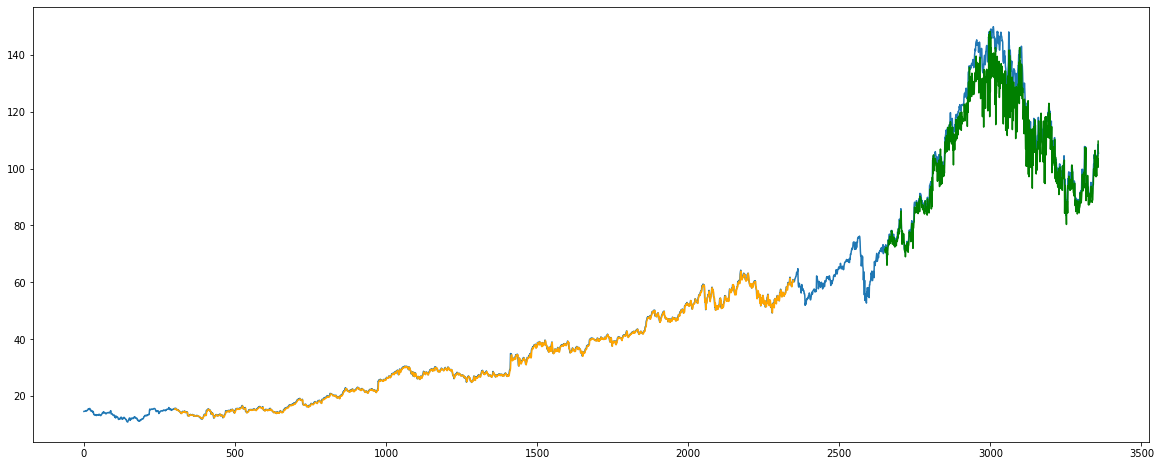

In [27]:
lags = time_step
var = data

# plot train_predict
train_pred_plot = np.empty_like(var)
train_pred_plot[:,:] = np.nan
train_pred_plot[lags:len(train_pred)+lags, :] = train_pred
# plot test_predict
test_pred_plot = np.empty_like(var)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+lags*2+1 : len(var)-1, :] = test_pred

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(var))
plt.plot(train_pred_plot, color='orange')
plt.plot(test_pred_plot, color='green')
plt.show()

# plt.figure(figsize=(20,8))
# plt.plot(scaler.inverse_transform(var)[1150:1258, :])
# plt.plot(train_pred_plot[1150:1258, :])
# plt.plot(test_pred_plot[1150:1258, :])
# plt.show()

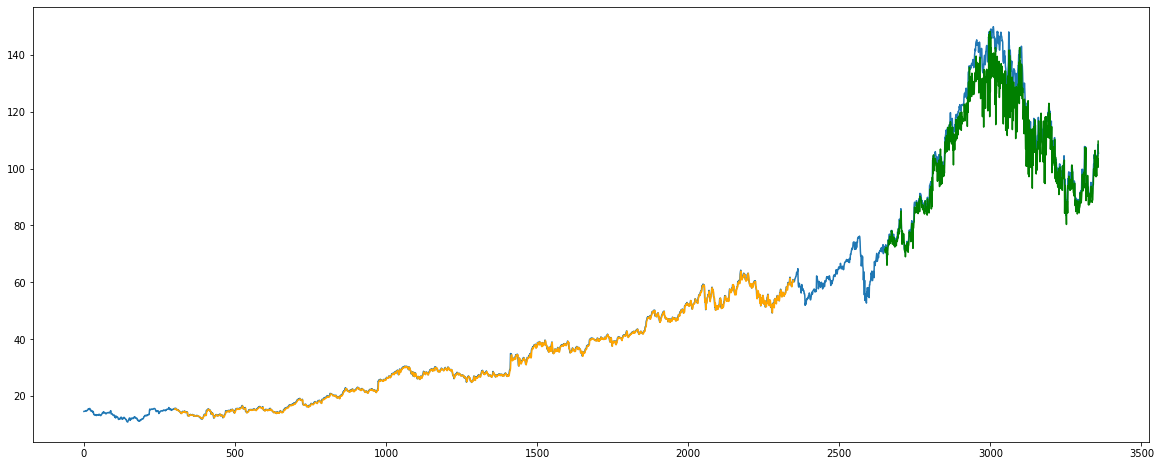

In [28]:
lags = time_step
var = data

# plot train_predict
train_pred_plot = np.empty_like(var)
train_pred_plot[:,:] = np.nan
train_pred_plot[lags:len(train_pred)+lags, :] = train_pred
# plot test_predict
test_pred_plot = np.empty_like(var)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+lags*2+1 : len(var)-1, :] = test_pred

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(var))
plt.plot(train_pred_plot, color='orange')
plt.plot(test_pred_plot, color='green')
plt.show()

# plt.figure(figsize=(20,8))
# plt.plot(scaler.inverse_transform(var)[1150:1258, :])
# plt.plot(train_pred_plot[1150:1258, :])
# plt.plot(test_pred_plot[1150:1258, :])
# plt.show()

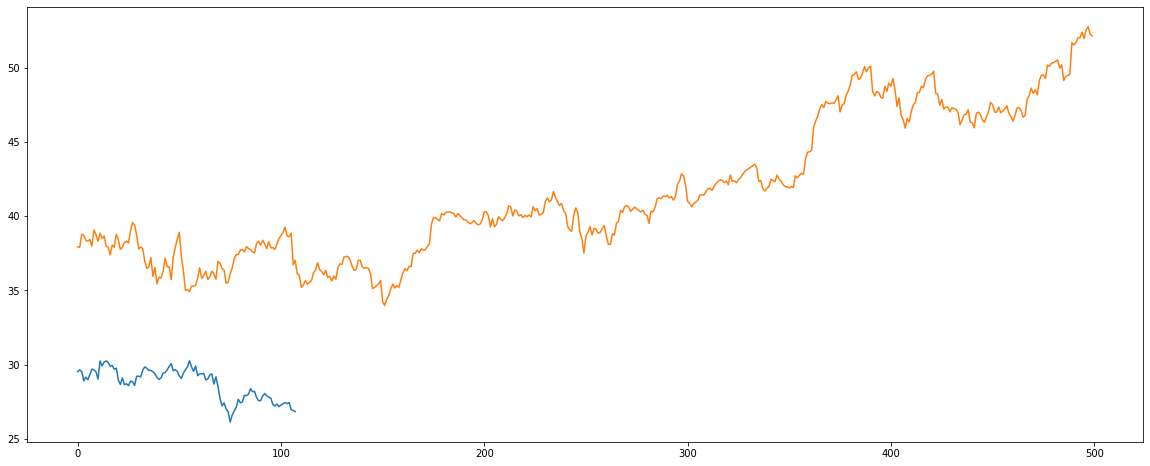

In [29]:
lags = time_step
var = data

# plot train_predict
train_pred_plot = np.empty_like(var)
train_pred_plot[:,:] = np.nan
train_pred_plot[lags:len(train_pred)+lags, :] = train_pred
# plot test_predict
test_pred_plot = np.empty_like(var)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+lags*2+1 : len(var)-1, :] = test_pred

# plt.figure(figsize=(20,8))
# plt.plot(scaler.inverse_transform(var))
# plt.plot(train_pred_plot, color='orange')
# plt.plot(test_pred_plot, color='green')
# plt.show()

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(var)[1150:1258, :])
plt.plot(train_pred_plot[1500:2000, :])
plt.plot(test_pred_plot[1500:2000, :])
plt.show()

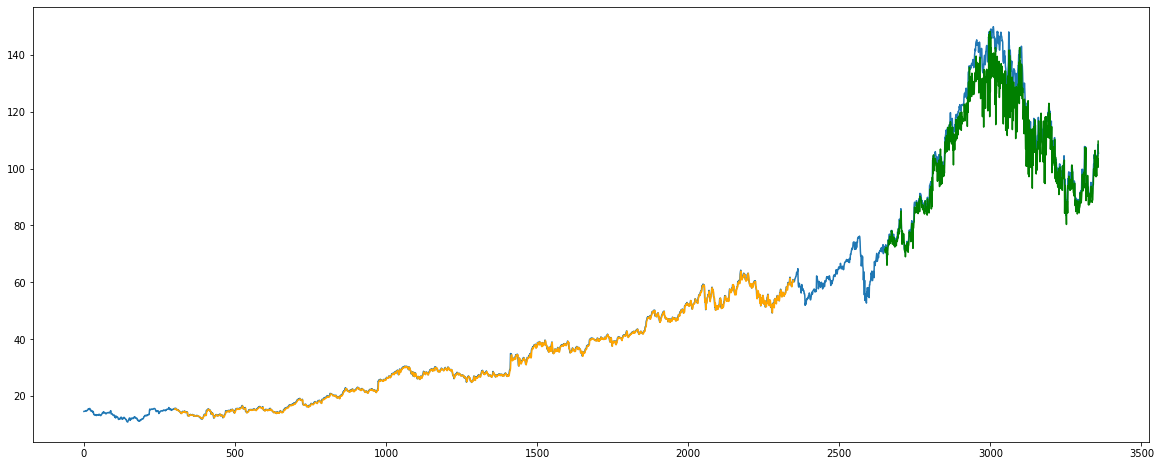

In [30]:
lags = time_step
var = data

# plot train_predict
train_pred_plot = np.empty_like(var)
train_pred_plot[:,:] = np.nan
train_pred_plot[lags:len(train_pred)+lags, :] = train_pred
# plot test_predict
test_pred_plot = np.empty_like(var)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+lags*2+1 : len(var)-1, :] = test_pred

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(var))
plt.plot(train_pred_plot, color='orange')
plt.plot(test_pred_plot, color='green')
plt.show()

# plt.figure(figsize=(20,8))
# plt.plot(scaler.inverse_transform(var)[1500:2000, :])
# plt.plot(train_pred_plot[1500:2000, :])
# plt.plot(test_pred_plot[1500:2000, :])
# plt.show()

In [31]:
l_t = len(test_data)

In [36]:
x_new = test_data[l_t-lags:]
x_new = x_new.reshape(1,-1)
t = x_new[0,-1].reshape(-1, 1)
l = []
forward = 30
for i in range(forward):
    val = model.predict(x_new)
    x_new = np.append(x_new[:,1:lags], val).reshape(1,-1)
    l.append(val.item())
l = np.array(l).reshape(-1,1)
L = scaler.inverse_transform(l)
L.shape


1/1 [==============================] - 0s 48ms/step


(30, 1)

In [37]:

T = scaler.inverse_transform(t)
L_final = np.append(T, L).reshape(-1,1)
L_final.shape, T

((31, 1), array([[105.34999847]]))

In [38]:
forward_plot_predict = np.empty([len(data)+forward,1])
forward_plot_predict[:, :] = np.nan
forward_plot_predict[len(data)-1:, :] = L_final
len(data), len(forward_plot_predict)

(3359, 3389)

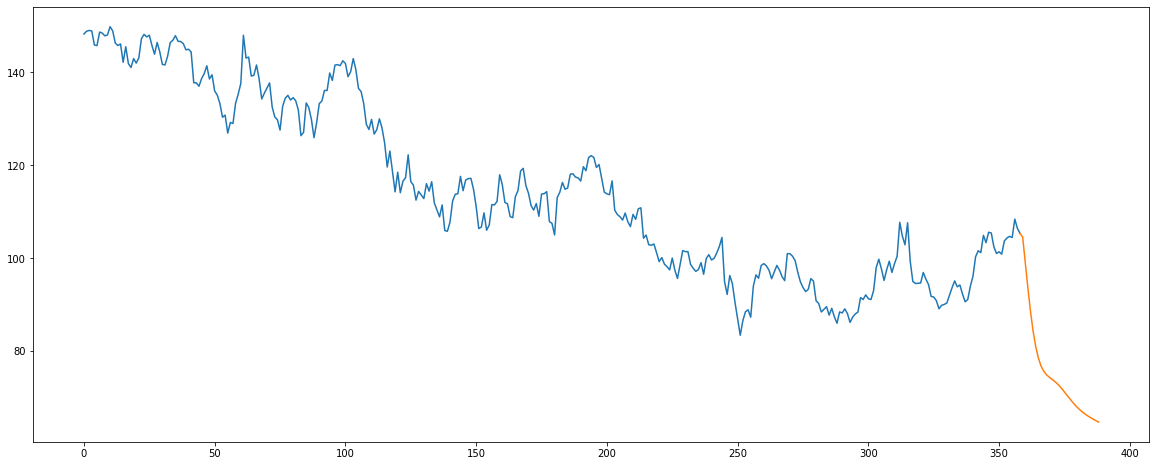

In [39]:
# plotting the graph
plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(data)[3000:,:])
plt.plot(forward_plot_predict[3000:, :])
plt.show()